In [1]:
!wget https://www.dropbox.com/s/y9hooknj3zmeqmw/data.zip

--2019-11-20 10:00:57--  https://www.dropbox.com/s/y9hooknj3zmeqmw/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/y9hooknj3zmeqmw/data.zip [following]
--2019-11-20 10:00:57--  https://www.dropbox.com/s/raw/y9hooknj3zmeqmw/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1597d7ff78871a93b0cf959705.dl.dropboxusercontent.com/cd/0/inline/AsvEudzgnCH-SZLbuU0W-yRs3pXw6YCVpUxBE8iDkDbxhI6bIDrimxIih6FB1jsfMjL53yBo_97M4AyilFiUIWNNxa2yW0IHNDepstG0CCNkdgQTGGz04D_800K3FDBl48c/file# [following]
--2019-11-20 10:00:58--  https://uc1597d7ff78871a93b0cf959705.dl.dropboxusercontent.com/cd/0/inline/AsvEudzgnCH-SZLbuU0W-yRs3pXw6YCVpUxBE8iDkDbxhI6bIDrimxIih6FB1jsfMjL53yBo_97M4AyilFiUIWNNxa2yW0IHNDepstG0CCNkdgQTGGz04D_800K

In [2]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/test/
   creating: data/test/cats/
  inflating: data/test/cats/cat.250.jpg  
  inflating: data/test/cats/cat.251.jpg  
  inflating: data/test/cats/cat.252.jpg  
  inflating: data/test/cats/cat.253.jpg  
  inflating: data/test/cats/cat.254.jpg  
  inflating: data/test/cats/cat.255.jpg  
  inflating: data/test/cats/cat.256.jpg  
  inflating: data/test/cats/cat.257.jpg  
  inflating: data/test/cats/cat.258.jpg  
  inflating: data/test/cats/cat.259.jpg  
  inflating: data/test/cats/cat.260.jpg  
  inflating: data/test/cats/cat.261.jpg  
  inflating: data/test/cats/cat.262.jpg  
  inflating: data/test/cats/cat.263.jpg  
  inflating: data/test/cats/cat.264.jpg  
  inflating: data/test/cats/cat.265.jpg  
  inflating: data/test/cats/cat.266.jpg  
  inflating: data/test/cats/cat.267.jpg  
  inflating: data/test/cats/cat.268.jpg  
  inflating: data/test/cats/cat.269.jpg  
  inflating: data/test/cats/cat.270.jpg  
  inflating: data/test/cats/cat.271.j

In [0]:
# Base variables
import os
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

train_size, validation_size, test_size = 200, 100, 100

img_width, img_height = 224, 224  # Default input size for VGG16

Using TensorFlow backend.


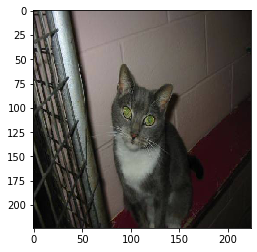

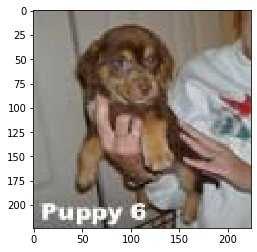

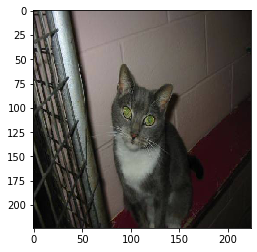

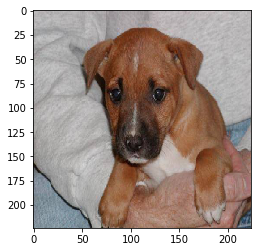

In [4]:
# Show pictures
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_cats_dir)
    show_pictures(train_dogs_dir)

In [5]:
# Instantiate convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures





58892288/58889256 [==============================] - 3s 0us/step








In [6]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
# Debug
print(train_features)
print(train_labels)

[[[[0.20825726 0.         0.         ... 0.         0.77813786
    0.        ]
   [0.22808652 0.         0.         ... 0.         0.53887701
    0.        ]
   [0.         0.         0.         ... 0.         0.47619879
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.3788932
    0.        ]
   [0.32902944 0.         0.3398129  ... 0.         0.48457173
    0.        ]
   [0.14807779 0.         0.70604765 ... 0.         0.5750922
    0.        ]]

  [[0.33507884 0.         0.19934225 ... 0.         0.48413298
    0.        ]
   [0.79916632 0.         0.24973106 ... 0.         0.44495946
    0.        ]
   [0.63414288 0.         0.         ... 0.         0.21454513
    0.        ]
   ...
   [0.48173314 0.         0.         ... 0.         0.16826355
    0.        ]
   [0.86342919 0.         0.21590781 ... 0.         0.09610784
    0.        ]
   [0.61993557 0.         0.35484487 ... 0.         0.22267792
    0.        ]]

  [[0.12647772 0.         0.10533917

In [9]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))



Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 2.3781 - acc: 0.5550 - val_loss: 0.6826 - val_acc: 0.5400
Epoch 2/100
200/200 [==============================] - 0s 728us/step - loss: 1.0491 - acc: 0.6400 - val_loss: 0.5312 - val_acc: 0.7300
Epoch 3/100
200/200 [==============================] - 0s 700us/step - loss: 0.4458 - acc: 0.7600 - val_loss: 0.3806 - val_acc: 0.8600
Epoch 4/100
200/200 [==============================] - 0s 684us/step - loss: 0.2539 - acc: 0.8900 - val_loss: 0.4306 - val_acc: 0.7900
Epoch 5/100
200/200 [==============================] - 0s 690us/step - loss: 0.1932 - acc: 0.9450 - val_loss: 0.3762 - val_acc: 0.8500
Epoch 6/100
200/200 [==============================] - 0s 670us/step - loss: 0.1700 - acc: 0.9400 - val_loss: 0.3587 - val_acc: 0.8600
Epoch 7/100
200/200 [==============================] - 0s 661us/step - loss: 0.1295 - acc: 0.9650 - val_loss: 0.3595 - val_acc: 0.8600
Epoch 8/1

In [0]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice(['/content/data/test/cats', '/content/data/test/dogs'])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Cat')
        else:
            print('Dog')

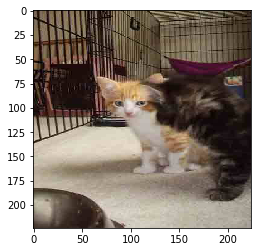

Cat


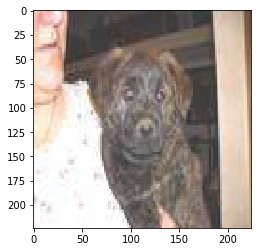

Cat


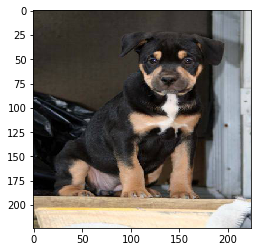

Cat


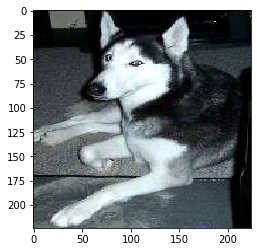

Cat


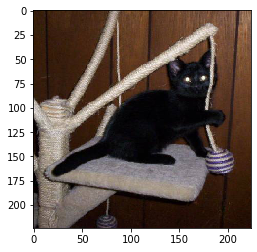

Cat


In [13]:
# Visualize predictions
visualize_predictions(model, 5)

In [0]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [15]:
!pip install scikit-learn

In [0]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(300,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

In [0]:
# Save model
model.save('dogs_cat_svm.h5')

In [0]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (mean):


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

0.8700000000000001

Accuracy score (standard deviation):


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

0.05044248650140518


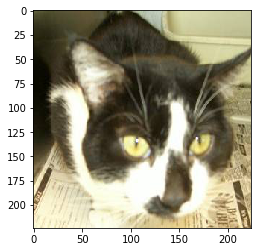

Cat


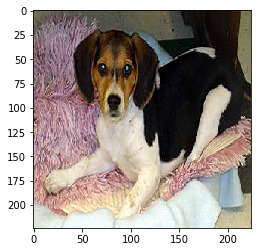

Dog


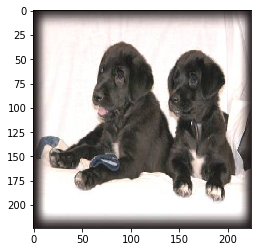

Dog


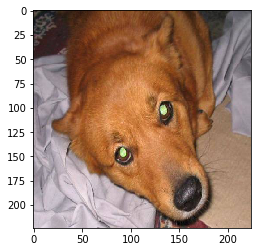

Cat


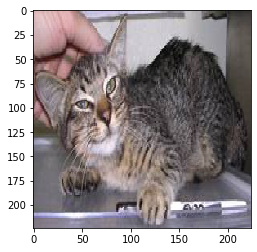

Cat


In [0]:
# Visualize predictions
visualize_predictions(clf, 5)